In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [96]:
train_df = pd.read_csv("data/Simple_Train_norm.csv")
test_df = pd.read_csv("data/Simple_Test_norm.csv")
print(train_df.head())

toplot = test_df.loc[:,['Date','pm2.5_mean_diff']]
#toplot.plot()

         Date  prev_min  prev_max  prev_mean  current_diff  current_min  \
0  2010-01-16  0.279987  0.207234   0.282025      0.440038     0.128099   
1  2010-01-17  0.163837  0.139213   0.170977      0.473998     0.094595   
2  2010-01-18  0.090127  0.113476   0.092396      0.483701     0.074492   
3  2010-01-19  0.101296  0.138294   0.110801      0.473880     0.065557   
4  2010-01-20  0.090127  0.162193   0.133893      0.479086     0.070025   

   curent_max  current_mean  pm2.5_mean_diff  
0    0.223543      0.186969         0.578797  
1    0.122844      0.135271         0.638276  
2    0.066900      0.073647         0.721816  
3    0.075291      0.074888         0.797348  
4    0.130303      0.107079         0.537145  


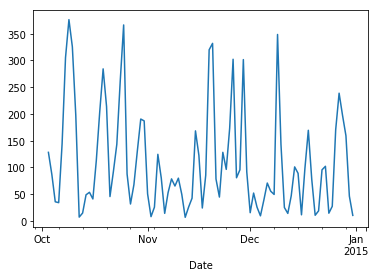

In [76]:
series = pd.read_csv("data/Last_90_days.csv", header=0, index_col=0, parse_dates=True, squeeze=True)
series.plot()
#series

In [101]:
features = ['current_diff', 'current_mean','current_min','curent_max']
input_length = len(features)

X = train_df.loc[:,features].values

target = 'pm2.5_mean_diff'
y = train_df.loc[:,[target]].values

X_test = test_df.loc[:,features].values
y_test = test_df.loc[:,[target]].values
test_dates = test_df.loc[:,['Date']].values


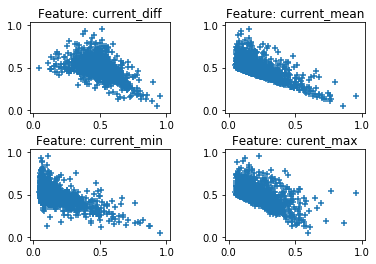

In [115]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.scatter(X[:,i-1], y, marker='+', label=features[i-1])
    plt.title('Feature: ' + features[i-1])


In [163]:
from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer
import keras
print(keras.__version__)

import tensorflow as tf
import tensorflow_probability as tfp
def mixture_prior_params(sigma_1, sigma_2, pi, return_sigma=False):
    params = K.variable([sigma_1, sigma_2, pi], name='mixture_prior_params')
    sigma = np.sqrt(pi * sigma_1 ** 2 + (1 - pi) * sigma_2 ** 2)
    return params, sigma

def log_mixture_prior_prob(w):
    comp_1_dist = tfp.distributions.Normal(0.0, prior_params[0])
    comp_2_dist = tfp.distributions.Normal(0.0, prior_params[1])
    comp_1_weight = prior_params[2]    
    return K.log(comp_1_weight * comp_1_dist.prob(w) + (1 - comp_1_weight) * comp_2_dist.prob(w))    

# Mixture prior parameters shared across DenseVariational layer instances
prior_params, prior_sigma = mixture_prior_params(sigma_1=1.0, sigma_2=0.2, pi=0.2)

class DenseVariational(Layer):
    def __init__(self, output_dim, kl_loss_weight, activation=None, **kwargs):
        self.output_dim = output_dim
        self.kl_loss_weight = kl_loss_weight
        self.activation = activations.get(activation)
        super().__init__(**kwargs)

    def build(self, input_shape):  
        self._trainable_weights.append(prior_params) 

        self.kernel_mu = self.add_weight(name='kernel_mu', 
                                         shape=(input_shape[1], self.output_dim),
                                         initializer=initializers.normal(stddev=prior_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu', 
                                       shape=(self.output_dim,),
                                       initializer=initializers.normal(stddev=prior_sigma),
                                       trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho', 
                                          shape=(input_shape[1], self.output_dim),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho', 
                                        shape=(self.output_dim,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)

    def call(self, x):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)
                
        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) + 
                      self.kl_loss(bias, self.bias_mu, bias_sigma))
        
        return self.activation(K.dot(x, kernel) + bias)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def kl_loss(self, w, mu, sigma):
        variational_dist = tfp.distributions.Normal(mu, sigma)
        return self.kl_loss_weight * K.sum(variational_dist.log_prob(w) - log_mixture_prior_prob(w))



2.3.1


In [172]:
from keras.layers import Input
from keras.models import Model

batch_size = train_size
num_batches = train_size / batch_size
kl_loss_weight = 1.0 / num_batches

x_in = Input(shape=(4,))
x = DenseVariational(20, kl_loss_weight=kl_loss_weight, activation='relu')(x_in)
x = DenseVariational(20, kl_loss_weight=kl_loss_weight, activation='relu')(x)
x = DenseVariational(1, kl_loss_weight=kl_loss_weight)(x)

model = Model(x_in, x)
print(model)
print( X.shape )

(1618, 4)


In [176]:
from keras import callbacks, optimizers
noise = 0.6
def neg_log_likelihood(y_obs, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

model.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=0.03), metrics=['mse'])
model.fit(X, y, batch_size=batch_size, epochs=1000, verbose=0);
print("Model Trained!")

Model Trained!


In [181]:
import tqdm

y_pred_list = []

for i in tqdm.tqdm(range(1000)):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)


100%|██████████| 1000/1000 [00:03<00:00, 313.88it/s]


Dates:  90
Preds:  90


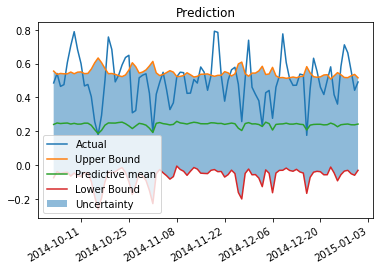

In [182]:
import datetime as d
import matplotlib.dates as mdates

mydates = test_df['Date'].tolist()
dateset = [dt.datetime.strptime(d, "%Y-%m-%d").date() for d in mydates ]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d") )

upper_bound = y_mean + 0.5 * y_sigma
lower_bound = y_mean - 0.5 * y_sigma

print( "Dates: ", len(dateset) )
print( "Preds: ", len(y_mean) )

plt.plot(dateset, y_test, label='Actual')
plt.plot(dateset, upper_bound, label='Upper Bound')
plt.plot(dateset, y_mean, label='Predictive mean')
plt.plot(dateset, lower_bound, label='Lower Bound')

plt.fill_between(dateset, upper_bound, lower_bound, 
                 alpha=0.5, label='Uncertainty')

plt.gcf().autofmt_xdate()
plt.title('Prediction')
plt.legend();
